# Load DeepFly3D Data

In [6]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
       'out_dir'        : './out',
       'train_subjects' : [1],
       'test_subjects'  : [6,7],
       'actions'        : ['all'],
       'cam_id'         : [2,5]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, _, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, _, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [ ]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d, test_2d, train_3d, test_3d, rcams_train, rcams_test, 
      par['roots'], par['targets'], 2, par["out_dim"], par['out_dir'])

[main.py:86]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_2d.pth.tar.
[main.py:110]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/fly_tether/out/stat_3d.pth.tar.
[main.py:128]:INFO:Starting training model
[main.py:137]:DEBUG:
==================Options=================
[main.py:138]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'dropout': 0.5,
    'epochs': 2,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/fly_tether/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:139]:DEBUG:=================================

Epoch 0 | Loss Test 0 | Loss Train 0.30114|: 100%|██████████| 3291/3291 [00:34<00:00, 95.45it/s] 
/home/user/Desktop/LiftPose3D/liftpose/lifter/test.py:69: RuntimeWarning: Mean of empty slice
  joint_err = np.nanmean(all_dist, axis=0)
Epoch 1 | Loss Test 0.054918 | Loss Train 0.10302|:  63%|██████▎   | 2085/3291 [00:23<00:13, 90.49it/s] 

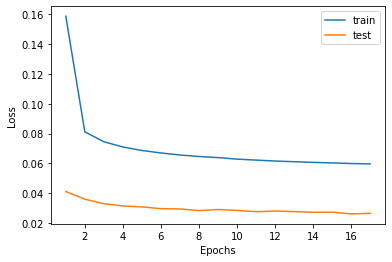

In [22]:
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [20]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:144]:INFO:starting testing in path: ./out
[lift.py:53]:INFO:total params: 4.27M
[lift.py:59]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:67]:INFO:ckpt loaded (epoch: 16 | err: 0.046560853719711304)


100%|██████████| 594/594 [00:01<00:00, 375.42it/s]

[test.py:72]:INFO:test error: 0.046560853719711304
[lift.py:97]:INFO:Saving results: /home/user/Desktop/LiftPose3D/examples/fly_tether/out/test_results.pth.tar


# Visualize Predictions

In [69]:
from liftpose.postprocess import load_test_results
test_3d, test_3d_pred = load_test_results(par['out_dir'])

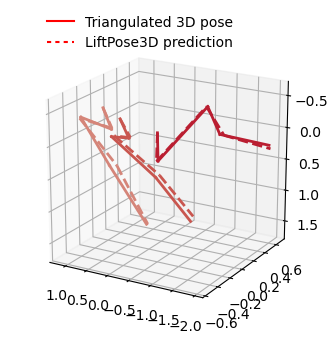

In [75]:
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 900
plot_pose_3d(ax, test_3d[t], 
            test_3d_pred[t], 
            par["ndims"], 
            np.array(params["vis"]["bones"][:12]), 
            par_data["vis"]["limb_id"], 
            par_data["vis"]["colors"])